<img align="right" width="100" height="100" src="https://jatinangor.itb.ac.id/wp-content/uploads/sites/17/2012/12/Logo-ITB-polos20-1.jpg">

## Seismologi Komputasi - Tugas 3
*Farhan Hamid Lubis - 22319310*<br>
*Rizky Adityo Prastama - 22319311*
***
#### Estimasi Traveltime - Finite Differences

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(precision = 2)
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)

<hr style="height: 2px; color: gray; background-color: gray">

# Pembuatan Grid

## Dimensi Grid

In [49]:
v = np.array([3.0, 3.0]) # km/s, shallow -> deep
v_dz = np.array([10, 20]) # layer thickness in km, shallow -> deep
layers = len(v) # number of layers

distance_x = 40 # km
distance_z = np.sum(v_dz)
h = 0.1 # grid spacing

grid_x = int(np.round((distance_x / h) + 1))
grid_z = int(np.round((distance_z / h) + 1))
grid = np.zeros([grid_z, grid_x])

# source location in grid
source = 1 # 1 = top left corner; 2 = top middle; 3 = top right corner
if source == 1:
    source_x = 0
    source_z = 0
elif source == 2:
    source_x = np.round(grid_x / 2)
    source_z = 0
elif source == 3:
    source_x = np.round(grid_x - 1)
    source_z = 0
else:
    print("Wrong source location index! Exiting program...")
    exit()

# cross-section coordinate matrix
x = np.arange(0, np.round(distance_x + h, decimals = 2), h)
z = np.arange(0, np.round(distance_z + h, decimals = 2), h)
x, z = np.meshgrid(x, z)

## Grid Kecepatan

In [50]:
v_z = np.zeros([1, layers + 1])
for i in range(1, layers + 1):
    v_z[0, i] = v_z[0, i - 1] + v_dz[i - 1]

v_grid = v_z / h

velo = np.zeros([grid_z, grid_x])

for j in range(np.shape(velo)[1]):
    for k in range(layers):
        for i in range(int(np.round(v_grid[0, k])), int(np.round(v_grid[0, k + 1]))):
            velo[i, j] = v[k]
            velo[i + 1, j] = v[k]

slowness = 1 / velo

<hr style="height: 2px; color: gray; background-color: gray">

# Perhitungan Waktu Tempuh ($t$)

## Perhitungan $t$ Sumbu Utama

Dari Vidale, waktu perambatan pada titik-titik yang sejajar secara lateral dan vertikal dari sumber dapat dihitung menggunakan persamaan berikut:
$$
t_{i} = \frac{h}{2} \left(s_{i} + s_{A}\right)
$$
dimana $t_{i}$ ada waktu pada titik $i$, $h$ adalah ukuran _spacing_ grid, $s_{i}$ adalah nilai _slowness_ pada titik $i$, dan $s_{A}$ adalah nilai _slowness_ pada titik sumber. Titik $A$ tidak selalu menjadi sumber ledakan, namun dapat menjadi titik yang berada tepat di sebelah titik $i$ yang sudah memiliki nilai $t$.

In [51]:
t = grid
t[int(source_z), int(source_x)] = 0

# print("Matriks t input: \n", t)

# lateral propagation from source
# left direction
for i in reversed(range(0, int(source_x))):
    t[int(source_z), i] = t[int(source_z), i + 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i + 1]))
# right direction
for i in range(int(source_x) + 1, grid_x):
    t[int(source_z), i] = t[int(source_z), i - 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i - 1]))

# vertical propagation from source
# upward direction
for i in reversed(range(0, int(source_z))):
    t[i, int(source_x)] = t[i + 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i + 1, int(source_x)]))
# downward direction
for i in range(int(source_z) + 1, grid_z):
    t[i, int(source_x)] = t[i - 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i - 1, int(source_x)]))
    
# print("\nMatriks t setelah perhitungan arah lateral dan vertikal dari sumber: \n", t)

## Perhitungan $t$ Diagonal

### Pendekatan 1

Pendekatan 1 memiliki tingkat akurasi ekstrapolasi nilai $t$ yang baik ketika bentuk muka gelombang dianggap rata atau _flat_. Perambatan gelombang dua dimensi mengikuti persamaan eikonal _ray tracing_ berikut:
$$
\left(\frac{\partial t}{\partial x}\right)^{2} + \left(\frac{\partial t}{\partial z}\right)^{2} = s\left(x, z\right)^{2}
$$
Dalam _finite differences_ , suku diferensial dapat didefinisikan sebagai berikut:
$$
\frac{\partial t}{\partial x} = \frac{1}{2h} \left(t_{0} + t_{2} - t_{1} - t_{3}\right) \\
\frac{\partial t}{\partial z} = \frac{1}{2h} \left(t_{0} + t_{1} - t_{2} - t_{3}\right)
$$
Sehingga:
$$
t_{3} = t_{0} + \sqrt{2(hs)^{2} - (t_{2} - t_{1})^2}
$$
dimana $t_{3}$ adalah waktu pada titik yang diapit oleh titik $1$ dan $2$ serta berseberangan dengan titik $0$ secara diagonal.

In [52]:
# print("Matriks t input: \n", t)

# right direction
for i in range(int(source_x) + 1, grid_x):
    # upper
    for j in reversed(range(0, int(source_z))):
        t[j, i] = t[j + 1, i - 1] + np.sqrt(2 * (h * slowness[j + 1, i - 1])**(2) - (t[j + 1, i] - t[j, i - 1])**(2))
    # lower
    for j in range(int(source_z) + 1, grid_z):
        t[j, i] = t[j - 1, i - 1] + np.sqrt(2 * (h * slowness[j - 1, i - 1])**(2) - (t[j - 1, i] - t[j, i - 1])**(2))

# print("\nMatriks t setelah perhitungan ke arah kanan dari sumber: \n", t)

# left direction
for i in reversed(range(0, int(source_x))):
    # upper
    for j in reversed(range(0, int(source_z))):
        t[j, i] = t[j + 1, i + 1] + np.sqrt(2 * (h * slowness[j + 1, i + 1])**(2) - (t[j + 1, i] - t[j, i + 1])**(2))
    # lower
    for j in range(int(source_z) + 1, grid_z):
        t[j, i] = t[j - 1, i + 1] + np.sqrt(2 * (h * slowness[j - 1, i + 1])**(2) - (t[j - 1, i] - t[j, i + 1])**(2))

# print("\nMatriks t setelah perhitungan ke arah kiri dari sumber: \n", t)

<hr style="height: 2px; color: gray; background-color: gray">

# Plotting

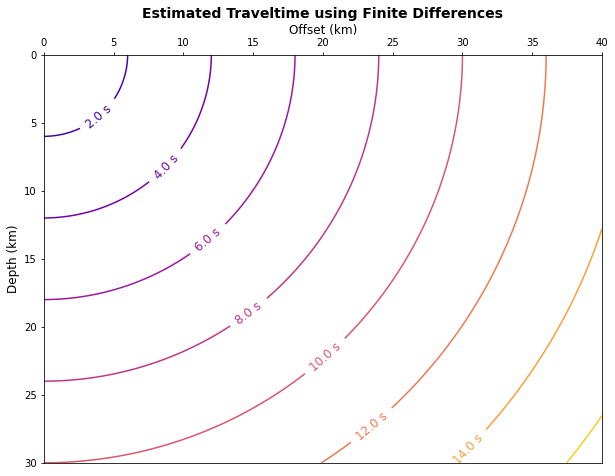

In [53]:
np.set_printoptions(precision = 2)

fig, ax = plt.subplots()
cs = ax.contour(x, z, t, levels = 10, cmap = 'plasma')


ax.set_title("Estimated Traveltime using Finite Differences", fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel("Offset (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})
ax.set_ylabel("Depth (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

fgz_scale = 10 # inches
fgz_x = (grid_x / max(grid_x, grid_z)) * fgz_scale
fgz_z = (grid_z / max(grid_x, grid_z)) * fgz_scale

fig.set_size_inches(fgz_x, fgz_z)
plt.gca().invert_yaxis()

ax.clabel(cs, inline=True, fontsize = '12', inline_spacing=5, fmt='%1.1f s')

plt.show()